In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [6]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

In [7]:
data_dir= '/content/drive/MyDrive/PlantDisease/Data'
categories = os.listdir(data_dir)

#Load images And Labels
images = []
labels = []

for category in categories:
  print(category)
  folder_path = os.path.join(data_dir,category)
  for img_file in os.listdir(folder_path):
    img_path = os.path.join(folder_path,img_file)
    img = cv2.imread(img_path)
    if img is not None:
           img = cv2.resize(img,(64,64)) #Resize To uniform Size
           images.append(img)
           labels.append(category)

# Convert Images And Labels To Numpy Arrays
images = np.array(images)

Tomato___Bacterial_spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Tomato_mosaic_virus
Tomato___Target_Spot
Tomato___Late_blight
Tomato___healthy
Tomato___Early_blight


In [8]:
#Convert To Numpy Arrays
x = np.array(images)
y = np.array(labels)

print("Labels:",np.unique(y))
print("Data Shape:",x.shape)


Labels: ['Tomato___Bacterial_spot' 'Tomato___Early_blight' 'Tomato___Late_blight'
 'Tomato___Target_Spot' 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
 'Tomato___Tomato_mosaic_virus' 'Tomato___healthy']
Data Shape: (12909, 64, 64, 3)


Class Distribution
Tomato___Tomato_Yellow_Leaf_Curl_Virus    1981
Tomato___healthy                          1926
Tomato___Early_blight                     1920
Tomato___Late_blight                      1861
Tomato___Target_Spot                      1827
Tomato___Tomato_mosaic_virus              1790
Tomato___Bacterial_spot                   1604
Name: count, dtype: int64


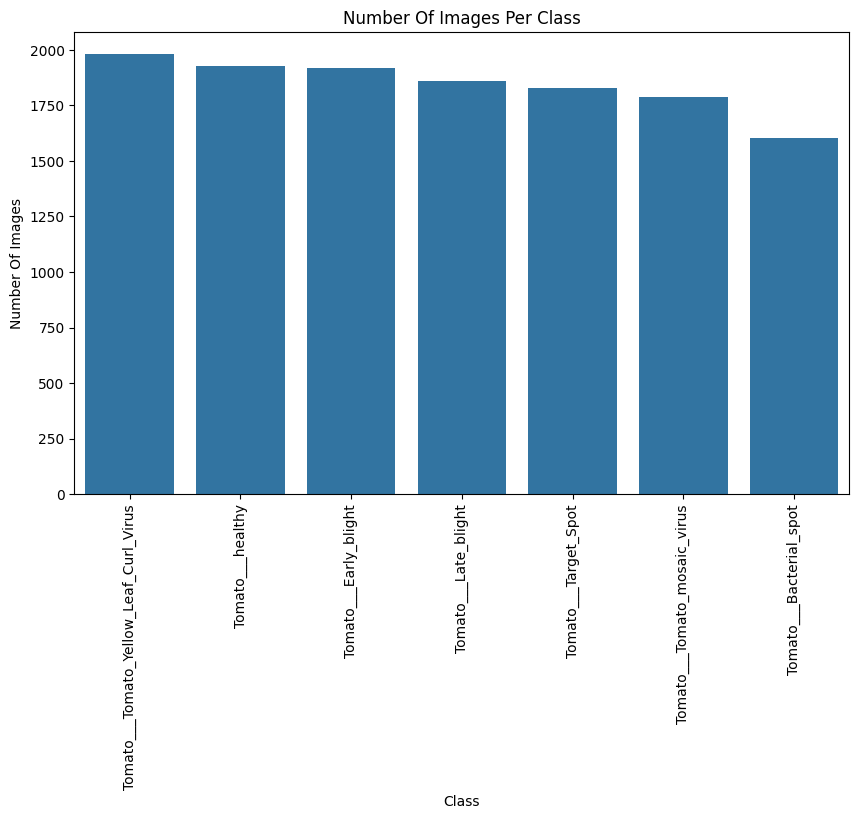

In [14]:
class_counts = pd.Series(y).value_counts()
print("Class Distribution")
print(class_counts)

#Plot Class Distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
sns.barplot(x=class_counts.index,y=class_counts.values)
plt.xticks(rotation=90)
plt.title("Number Of Images Per Class")
plt.xlabel("Class")
plt.ylabel("Number Of Images")
plt.show()

In [16]:
#Remove Corrupted Images
valid_images= []
valid_labels= []

for img,label in zip(x,y):
  if img.shape == (64,64,3):
    valid_images.append(img)
    valid_labels.append(label)

x= np.array(valid_images)
y= np.array(valid_labels)

print("Cleaned Data Shape:",x.shape)


Cleaned Data Shape: (12909, 64, 64, 3)


In [17]:
#Encode Labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

#Save Class Names For Later use
class_names = le.classes_
class_names


array(['Tomato___Bacterial_spot', 'Tomato___Early_blight',
       'Tomato___Late_blight', 'Tomato___Target_Spot',
       'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
       'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'], dtype='<U38')

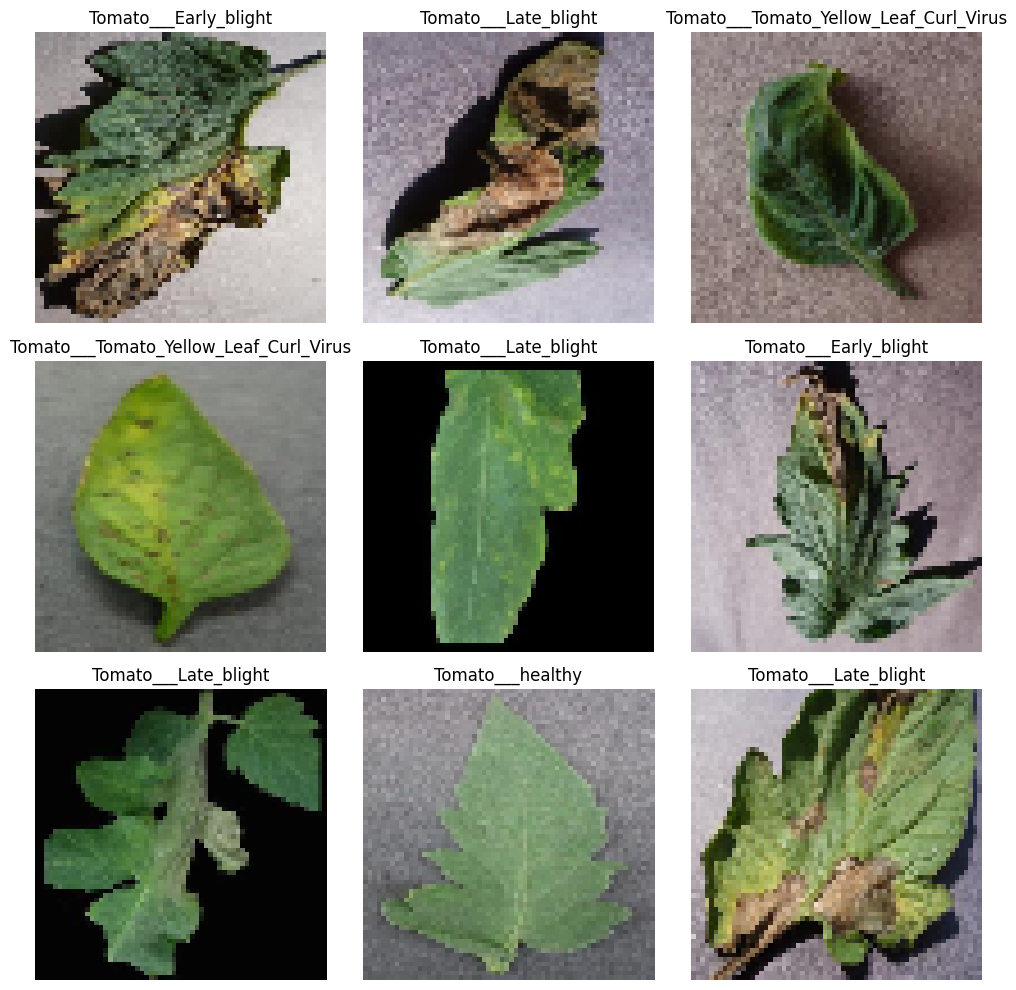

In [19]:
import random

plt.figure(figsize=(10,10))
for i in range(9):
  idx= random.randint(0,len(x))
  plt.subplot(3,3,i+1)
  plt.imshow(cv2.cvtColor(x[idx],cv2.COLOR_BGR2RGB))
  plt.title(class_names[y_encoded[idx]])
  plt.axis('off')
plt.tight_layout()
plt.show()

In [22]:
def extract_color_histogram(image,bins=(8,8,8)):

  image = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
  hist = cv2.calcHist([image],[0,1,2],None,bins,[0,256,0,256,0,256])
  hist = cv2.normalize(hist,hist).flatten()
  return hist

hist_features = [extract_color_histogram(img) for img in x]
x_features  = np.array(hist_features)

In [23]:
x_features.shape

(12909, 512)

In [24]:
#Choose Model
model = SVC(kernel='rbf',gamma='scale')

In [26]:

#Train/Test Split

X_train,X_test,y_train,y_test = train_test_split(x_features,y_encoded,test_size=0.2,random_state=42)

#Train Model
model.fit(X_train,y_train)

#Predict Model
y_pred = model.predict(X_test)

Accuracy: 0.9442292796281953
F1 Score: 0.9439468712957007


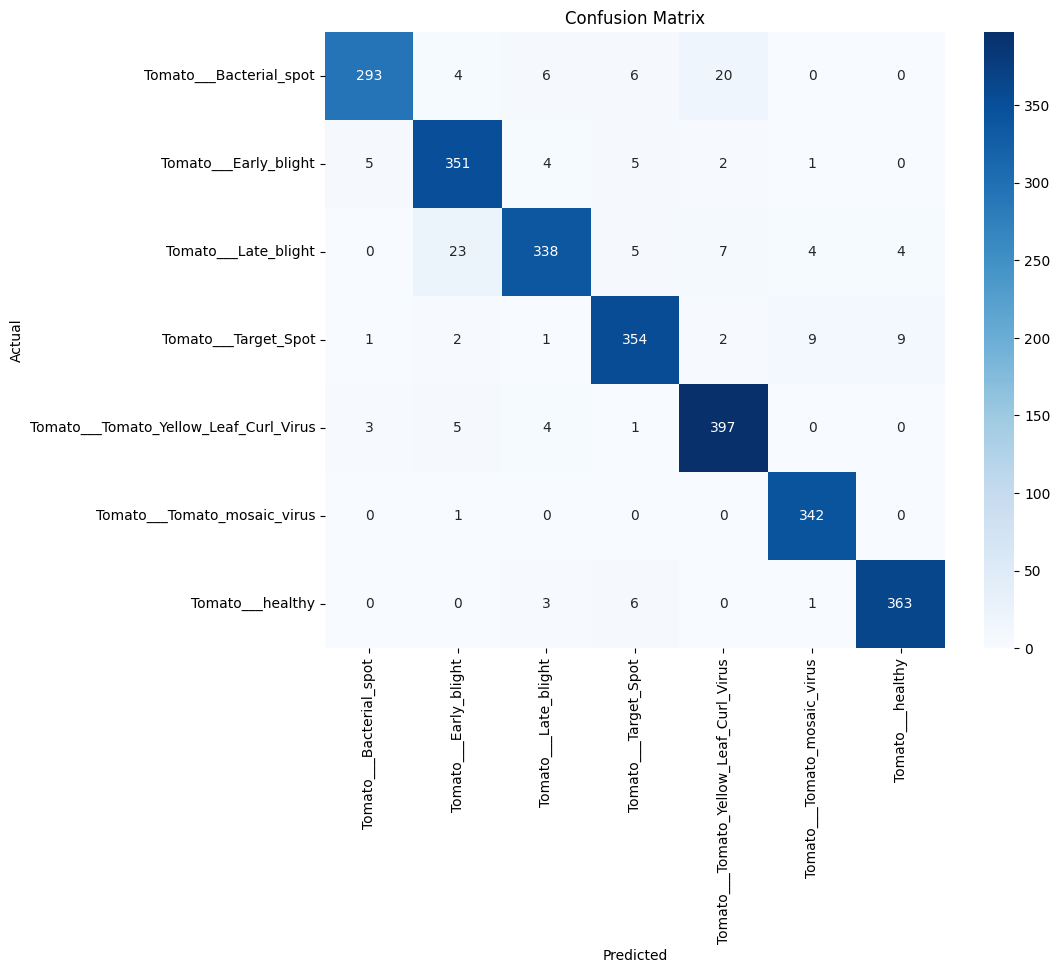

In [30]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report

#Accuracy
acc=accuracy_score(y_test,y_pred)
print("Accuracy:",acc)

#F1 Score
f1=f1_score(y_test,y_pred,average='weighted')
print("F1 Score:",f1)

#Confusion Matrix
cm=confusion_matrix(y_test,y_pred)

#Plot Confusion Matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [29]:
#Classification Report
print("Classification Report")
print(classification_report(y_test,y_pred,target_names=class_names))

Classification Report
                                        precision    recall  f1-score   support

               Tomato___Bacterial_spot       0.97      0.89      0.93       329
                 Tomato___Early_blight       0.91      0.95      0.93       368
                  Tomato___Late_blight       0.95      0.89      0.92       381
                  Tomato___Target_Spot       0.94      0.94      0.94       378
Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.93      0.97      0.95       410
          Tomato___Tomato_mosaic_virus       0.96      1.00      0.98       343
                      Tomato___healthy       0.97      0.97      0.97       373

                              accuracy                           0.94      2582
                             macro avg       0.95      0.94      0.94      2582
                          weighted avg       0.94      0.94      0.94      2582

